## Shortest paths

### First, import the necessary packages.

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations
from gurobipy import *

### Then, we "read" a (weighted -- distances) edge list from a file. 

#### You'd need to have a folder called Instances in the same place as your code for the rest to work.

In [2]:
G=nx.read_weighted_edgelist("./Instances/SiouxFalls.txt")

### Let's play with Dijkstra's a little bit.

In [3]:
## This prints the shortest path (using Dijkstra's) between two nodes (1 and 5 in the example)
print(nx.dijkstra_path(G, u'1', u'5', weight='weight')) 
## The shortest path is presented in a list of nodes (i.e., 1->3->4->5 here)

## Following is a way to get all pairs shortest paths.
for (s,t) in combinations(G.nodes(),2):
    print("From", s, "To", t)
    print(nx.dijkstra_path(G, s, t, weight='weight'))

['1', '3', '4', '5']
From 1 To 2
['1', '2']
From 1 To 3
['1', '3']
From 1 To 6
['1', '2', '6']
From 1 To 4
['1', '3', '4']
From 1 To 12
['1', '3', '12']
From 1 To 5
['1', '3', '4', '5']
From 1 To 11
['1', '3', '4', '11']
From 1 To 9
['1', '3', '4', '5', '9']
From 1 To 8
['1', '2', '6', '8']
From 1 To 7
['1', '2', '6', '8', '7']
From 1 To 18
['1', '2', '6', '8', '7', '18']
From 1 To 16
['1', '2', '6', '8', '16']
From 1 To 10
['1', '3', '4', '5', '9', '10']
From 1 To 15
['1', '3', '4', '5', '9', '10', '15']
From 1 To 17
['1', '3', '4', '5', '9', '10', '17']
From 1 To 14
['1', '3', '4', '11', '14']
From 1 To 13
['1', '3', '12', '13']
From 1 To 24
['1', '3', '12', '13', '24']
From 1 To 23
['1', '3', '12', '13', '24', '23']
From 1 To 19
['1', '3', '4', '5', '9', '10', '15', '19']
From 1 To 22
['1', '3', '12', '13', '24', '23', '22']
From 1 To 20
['1', '2', '6', '8', '7', '18', '20']
From 1 To 21
['1', '3', '12', '13', '24', '21']
From 2 To 3
['2', '1', '3']
From 2 To 6
['2', '6']
From 2 To 

#### We could have achieved the above using *all_pairs_shortest_paths* too.

In [4]:
all_shortest_paths=dict(nx.all_pairs_shortest_path(G))
print(all_shortest_paths['1']['7'])

['1', '2', '6', '8', '7']


### Finally we may get the number of arcs in the path or the length of the path.

In [5]:
print(len(nx.shortest_path(G, u'1', u'5', weight='weight')))
print(nx.shortest_path_length(G, u'1', u'5', weight='weight'))

4
10.0


### For plotting purposes, we may find a shortest path, and then represent it in the full graph.

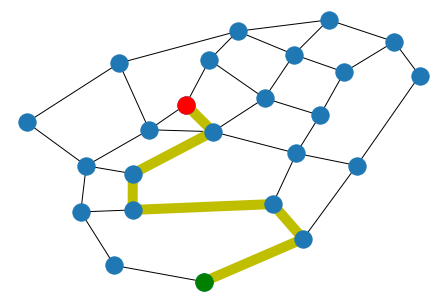

In [6]:
start='1'
end='17'
mySP=nx.shortest_path(G, start, end, weight='weight')

edges=[(mySP[j],mySP[j+1]) for j in range(len(mySP)-1)]

pos=nx.spring_layout(G)
nx.draw(G,pos)
nx.draw_networkx_nodes(G, pos, nodelist=[start], node_color='g')
nx.draw_networkx_nodes(G, pos, nodelist=[end], node_color='r')
nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color='y', width=10)

### How about through an optimization problem? Can we solve the formulation for the shortest path? Use Gurobi to do so.

As a reminder, here is the formulation:

$$\min \sum\limits_{\left(i,j\right)\in E} c_{ij}x_{ij}$$

$$\text{s.t.}~\sum\limits_{i:\left(i,j\right)\in E}x_{ij}-\sum\limits_{i:\left(j,i\right)\in E}x_{ji}=\begin{cases} 1, & \text{if}~ i=\text{start}, \\ -1, & \text{if}~ i=\text{end}, \\ 0, & \text{otherwise}. \end{cases}$$

$$ x_{ij} \geq 0, \forall (i,j)\in E.$$

Note how we set $$x_{ij}$$ to be binary, but may allow for it to just be nonnegative!

In [10]:
start='1'
end='17'
print("Shortest path: ", start, end)

## Create model 

modelName="shortest_path"+str(start)+str(end)
model=Model(modelName)
model.setParam('OutputFlag', 0); ## so that we do not have to see Gurobi's optimization messages.

## Add variables

x={}
for (i,j,d) in G.edges(data=True):
    x[i,j]=model.addVar(vtype=GRB.BINARY, obj=d['weight'])

print(G.edges)
## Flow preservation constraints    
    
inc={}
out={}
for i in G.nodes():
    inc[i]=0
    out[i]=0

for (i,j) in G.edges():
    inc[j]+=x[i,j]
    out[i]+=x[i,j]

for i in G.nodes():
    if i==start: ## if starting from i
        model.addConstr(out[i]-inc[i]==1)
    elif i==end: ## if ending in i
        model.addConstr(out[i]-inc[i]==-1)
    else: ## otherwise
        model.addConstr(out[i]-inc[i]==0)
        
## Optimizing and retrieving the solution 

model.optimize()
if model.status!=2: ## infeasibility status code
    print("no shortest path exists")
else:
    print("Edges in path:")
    for (i,j) in G.edges():
        if x[i,j].X==1:
            print("(",i,",",j,")")

Shortest path:  1 17
[('1', '2'), ('1', '3'), ('2', '6'), ('3', '4'), ('3', '12'), ('6', '5'), ('6', '8'), ('4', '5'), ('4', '11'), ('12', '11'), ('12', '13'), ('5', '9'), ('11', '10'), ('11', '14'), ('9', '8'), ('9', '10'), ('8', '7'), ('8', '16'), ('7', '18'), ('18', '16'), ('18', '20'), ('16', '10'), ('16', '17'), ('10', '15'), ('10', '17'), ('15', '14'), ('15', '19'), ('15', '22'), ('17', '19'), ('14', '23'), ('13', '24'), ('24', '21'), ('24', '23'), ('23', '22'), ('19', '20'), ('22', '20'), ('22', '21'), ('20', '21')]
Edges in path:
( 1 , 3 )
( 3 , 4 )
( 4 , 5 )
( 5 , 9 )
( 9 , 10 )
( 10 , 17 )


#### We could run it for all possible pairs.

In [8]:
for (k,l) in combinations(G.nodes(),2):
    print("Shortest path: ", k, l)
    modelName="shortest_path"+str(k)+str(l)
    model=Model(modelName)
    model.setParam('OutputFlag', 0);
    x={}
    for (i,j,d) in G.edges(data=True):
        x[i,j]=model.addVar(vtype=GRB.BINARY, obj=d['weight'])
    inc={}
    out={}
    for i in G.nodes():
        inc[i]=0
        out[i]=0

    for (i,j) in G.edges():
        inc[j]+=x[i,j]
        out[i]+=x[i,j]

    for i in G.nodes():
        if i==k:
            model.addConstr(out[i]-inc[i]==1)
        elif i==l:
            model.addConstr(out[i]-inc[i]==-1)
        else:
            model.addConstr(out[i]-inc[i]==0)
    model.optimize()
    if model.status!=2:
        print("no shortest path exists")
        continue
    else:
        print("Edges in path:")
        for (i,j) in G.edges():
            if x[i,j].X==1:
                print(i,j)

Shortest path:  1 2
Edges in path:
1 2
Shortest path:  1 3
Edges in path:
1 3
Shortest path:  1 6
Edges in path:
1 2
2 6
Shortest path:  1 4
Edges in path:
1 3
3 4
Shortest path:  1 12
Edges in path:
1 3
3 12
Shortest path:  1 5
Edges in path:
1 3
3 4
4 5
Shortest path:  1 11
Edges in path:
1 3
3 4
4 11
Shortest path:  1 9
Edges in path:
1 3
3 4
4 5
5 9
Shortest path:  1 8
Edges in path:
1 2
2 6
6 8
Shortest path:  1 7
Edges in path:
1 2
2 6
6 8
8 7
Shortest path:  1 18
Edges in path:
1 2
2 6
6 8
8 7
7 18
Shortest path:  1 16
Edges in path:
1 2
2 6
6 8
8 7
7 18
18 16
Shortest path:  1 10
Edges in path:
1 3
3 4
4 5
5 9
9 10
Shortest path:  1 15
Edges in path:
1 3
3 4
4 5
5 9
9 10
10 15
Shortest path:  1 17
Edges in path:
1 3
3 4
4 5
5 9
9 10
10 17
Shortest path:  1 14
Edges in path:
1 3
3 4
4 11
11 14
Shortest path:  1 13
Edges in path:
1 3
3 12
12 13
Shortest path:  1 24
Edges in path:
1 3
3 12
12 13
13 24
Shortest path:  1 23
Edges in path:
1 3
3 12
12 13
13 24
24 23
Shortest path:  1

16 17
17 19
Shortest path:  18 22
Edges in path:
18 16
16 10
10 15
15 22
Shortest path:  18 20
Edges in path:
18 20
Shortest path:  18 21
Edges in path:
18 20
20 21
Shortest path:  16 10
Edges in path:
16 10
Shortest path:  16 15
Edges in path:
16 10
10 15
Shortest path:  16 17
Edges in path:
16 17
Shortest path:  16 14
Edges in path:
16 10
10 15
15 14
Shortest path:  16 13
no shortest path exists
Shortest path:  16 24
no shortest path exists
Shortest path:  16 23
Edges in path:
16 10
10 15
15 14
14 23
Shortest path:  16 19
Edges in path:
16 17
17 19
Shortest path:  16 22
Edges in path:
16 10
10 15
15 22
Shortest path:  16 20
Edges in path:
16 17
17 19
19 20
Shortest path:  16 21
Edges in path:
16 17
17 19
19 20
20 21
Shortest path:  10 15
Edges in path:
10 15
Shortest path:  10 17
Edges in path:
10 17
Shortest path:  10 14
Edges in path:
10 15
15 14
Shortest path:  10 13
no shortest path exists
Shortest path:  10 24
no shortest path exists
Shortest path:  10 23
Edges in path:
10 15
15